## 인공지능과제 14
- DT 담당: 20186795 한동민

- Decision tree 필요 단계
0. 데이터 전처리
    - feature 중 float 가 아닌 데이터에 대해 전처리 진행.
    - name -> company 추출, power 등 단위가 있는 feature에 대해, 단위 제거 후 float 로 변환.
1. 데이터 분석 후, DT에 맞게 전처리 진행.
2. 기본적인 Decision tree 모델링
    - 하이퍼파라미터(max_depth 등 )
    - GridSearchCV 등을 통해 파라미터 튜닝 진행.


### Import

In [2]:
from __future__ import print_function
import os

from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib

import matplotlib.pyplot as plt

### 데이터 전처리

In [5]:
train_data = pd.read_csv('train.csv')

In [6]:
train_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [7]:
print(train_data.dtypes)

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object


In [8]:
train_data.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


object feature에 대한 결측치가 존재하는 데이터 삭제처리

In [9]:
train_data = train_data[train_data['Mileage'].notna()]
print(train_data.shape)
train_data = train_data[train_data['Engine'].notna()]
print(train_data.shape)
train_data = train_data[train_data['Power'].notna()]
print(train_data.shape)
train_data = train_data[train_data['Seats'].notna()]
print(train_data.shape)

(6017, 13)
(5981, 13)
(5981, 13)
(5975, 13)


In [10]:
print(train_data['Location'].unique())
print(train_data['Fuel_Type'].unique())
print(train_data['Transmission'].unique())
print(train_data['Owner_Type'].unique())

['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']
['CNG' 'Diesel' 'Petrol' 'LPG']
['Manual' 'Automatic']
['First' 'Second' 'Fourth & Above' 'Third']


최종 결측치 확인

In [11]:
train_data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                  0
Power                   0
Seats                   0
New_Price            5152
Price                   0
dtype: int64

In [12]:
train_data = train_data.reset_index(drop=True)

데이터 변환(object -> float , name -> brand category)

In [13]:
for i in range(train_data.shape[0]):
    train_data.at[i, 'Company'] = train_data['Name'][i].split()[0]
    train_data.at[i, 'Mileage(km/kg)'] = train_data['Mileage'][i].split()[0]
    train_data.at[i, 'Engine(CC)'] = train_data['Engine'][i].split()[0]
    train_data.at[i, 'Power(bhp)'] = train_data['Power'][i].split()[0]


In [14]:
x = 'n'
count = 0
position = []
for i in range(train_data.shape[0]):
    if train_data['Power(bhp)'][i]=='null':
        x = 'Y'
        count = count + 1
        position.append(i)
print("dummy data 여부" + x)
print(count)
print(position)

dummy data 여부Y
103
[76, 79, 89, 120, 143, 225, 242, 259, 304, 305, 383, 421, 425, 440, 469, 572, 628, 644, 645, 735, 744, 824, 910, 921, 929, 1063, 1138, 1148, 1266, 1313, 1338, 1380, 1411, 1546, 1569, 1640, 1663, 1848, 1989, 2043, 2118, 2152, 2250, 2254, 2292, 2328, 2377, 2425, 2434, 2481, 2485, 2511, 2561, 2579, 2616, 2621, 2868, 3010, 3038, 3081, 3166, 3224, 3266, 3414, 3491, 3506, 3562, 3601, 3611, 3618, 3642, 3706, 3868, 3900, 3969, 4046, 4049, 4318, 4321, 4593, 4672, 4676, 4706, 4792, 4848, 4862, 4914, 5024, 5078, 5186, 5383, 5395, 5415, 5486, 5490, 5604, 5712, 5716, 5818, 5830, 5881, 5899, 5941]


In [15]:
train_data = train_data.drop(train_data.index[position])
train_data = train_data.reset_index(drop=True)

In [16]:
train_data['Mileage(km/kg)'] = train_data['Mileage(km/kg)'].astype(float)
train_data['Engine(CC)'] = train_data['Engine(CC)'].astype(float)
train_data['Power(bhp)'] = train_data['Power(bhp)'].astype(float)
train_data['Year'] = train_data['Year'].astype(float)
train_data['Kilometers_Driven'] = train_data['Kilometers_Driven'].astype(float)


In [17]:
train_data.shape

(5872, 17)

In [18]:
train_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company,Mileage(km/kg),Engine(CC),Power(bhp)
0,Maruti Wagon R LXI CNG,Mumbai,2010.0,72000.0,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,Maruti,26.60,998.0,58.16
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015.0,41000.0,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50,Hyundai,19.67,1582.0,126.20
2,Honda Jazz V,Chennai,2011.0,46000.0,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50,Honda,18.20,1199.0,88.70
3,Maruti Ertiga VDI,Chennai,2012.0,87000.0,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00,Maruti,20.77,1248.0,88.76
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013.0,40670.0,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74,Audi,15.20,1968.0,140.80


In [19]:
for i in range(train_data.shape[0]):
    if pd.isnull(train_data.loc[i,'New_Price']) == False:
        train_data.at[i,'New_car_Price'] = train_data['New_Price'][i].split()[0]

train_data['New_car_Price'] = train_data['New_car_Price'].astype(float)

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5872 non-null   object 
 1   Location           5872 non-null   object 
 2   Year               5872 non-null   float64
 3   Kilometers_Driven  5872 non-null   float64
 4   Fuel_Type          5872 non-null   object 
 5   Transmission       5872 non-null   object 
 6   Owner_Type         5872 non-null   object 
 7   Mileage            5872 non-null   object 
 8   Engine             5872 non-null   object 
 9   Power              5872 non-null   object 
 10  Seats              5872 non-null   float64
 11  New_Price          823 non-null    object 
 12  Price              5872 non-null   float64
 13  Company            5872 non-null   object 
 14  Mileage(km/kg)     5872 non-null   float64
 15  Engine(CC)         5872 non-null   float64
 16  Power(bhp)         5872 

In [21]:
train_data['Kilometers_Driven'].value_counts()

60000.0    80
45000.0    69
65000.0    67
50000.0    60
55000.0    58
           ..
28937.0     1
82085.0     1
68465.0     1
63854.0     1
27365.0     1
Name: Kilometers_Driven, Length: 3038, dtype: int64

In [22]:
train_data.drop(["Name"],axis=1,inplace=True)
train_data.drop(["Mileage"],axis=1,inplace=True)
train_data.drop(["Engine"],axis=1,inplace=True)
train_data.drop(["Power"],axis=1,inplace=True)
train_data.drop(["New_Price"],axis=1,inplace=True)
# train_data.drop(["Location"],axis=1,inplace=True)
# train_data.drop(["Fuel_Type"],axis=1,inplace=True)
# train_data.drop(["Transmission"],axis=1,inplace=True)
# train_data.drop(["Owner_Type"],axis=1,inplace=True)
# train_data.drop(["Company"],axis=1,inplace=True)





In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5872 non-null   object 
 1   Year               5872 non-null   float64
 2   Kilometers_Driven  5872 non-null   float64
 3   Fuel_Type          5872 non-null   object 
 4   Transmission       5872 non-null   object 
 5   Owner_Type         5872 non-null   object 
 6   Seats              5872 non-null   float64
 7   Price              5872 non-null   float64
 8   Company            5872 non-null   object 
 9   Mileage(km/kg)     5872 non-null   float64
 10  Engine(CC)         5872 non-null   float64
 11  Power(bhp)         5872 non-null   float64
 12  New_car_Price      823 non-null    float64
dtypes: float64(8), object(5)
memory usage: 596.5+ KB


#### 남은 object data 처리.

In [24]:
train_data['Price'].describe()

count    5872.000000
mean        9.603919
std        11.249453
min         0.440000
25%         3.517500
50%         5.750000
75%        10.000000
max       160.000000
Name: Price, dtype: float64

/Users/handongmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 100.0)

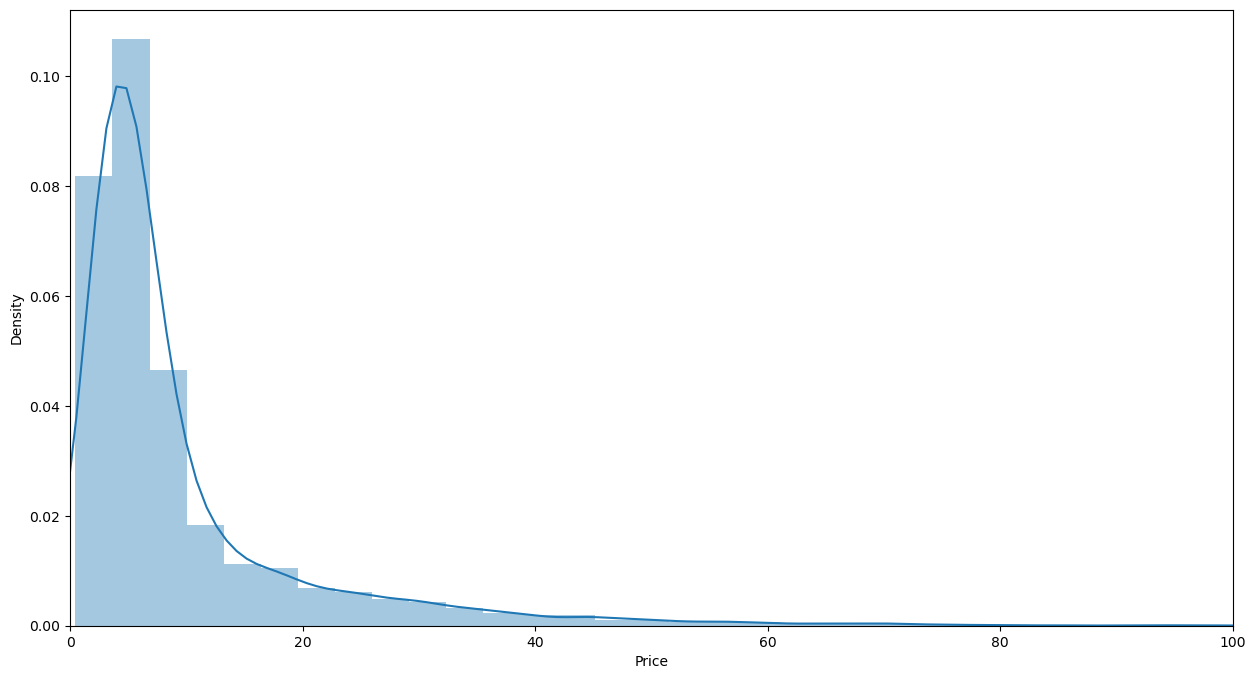

In [25]:
f, ax = plt.subplots(figsize=(15,8))
sns.distplot(train_data['Price'])
plt.xlim([0,100])

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

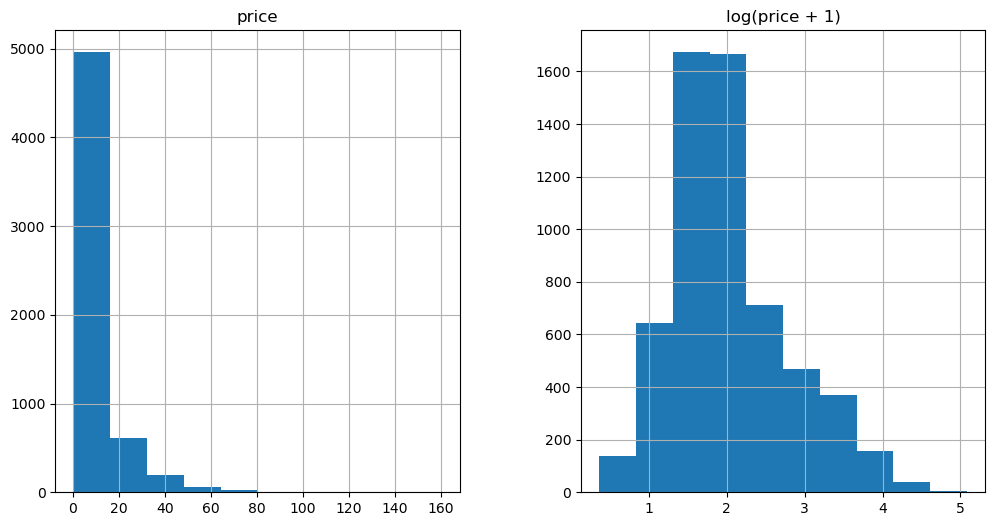

In [26]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train_data["Price"], "log(price + 1)":np.log1p(train_data["Price"])})
prices.hist()

In [27]:
train_data['Fuel_Type'].describe()

count       5872
unique         4
top       Diesel
freq        3152
Name: Fuel_Type, dtype: object

아래의 fuel_type에 대한 가격에 대한 분포도를 상자 수염 그림으로 확인한 모습이다. 중위값은 diesel이 가장 크고, 상대적으로 유사하나 diesel과 petrol이 박스를 초과한 데이터(높은 가격)가 많은 것을 확인할 수 있다.

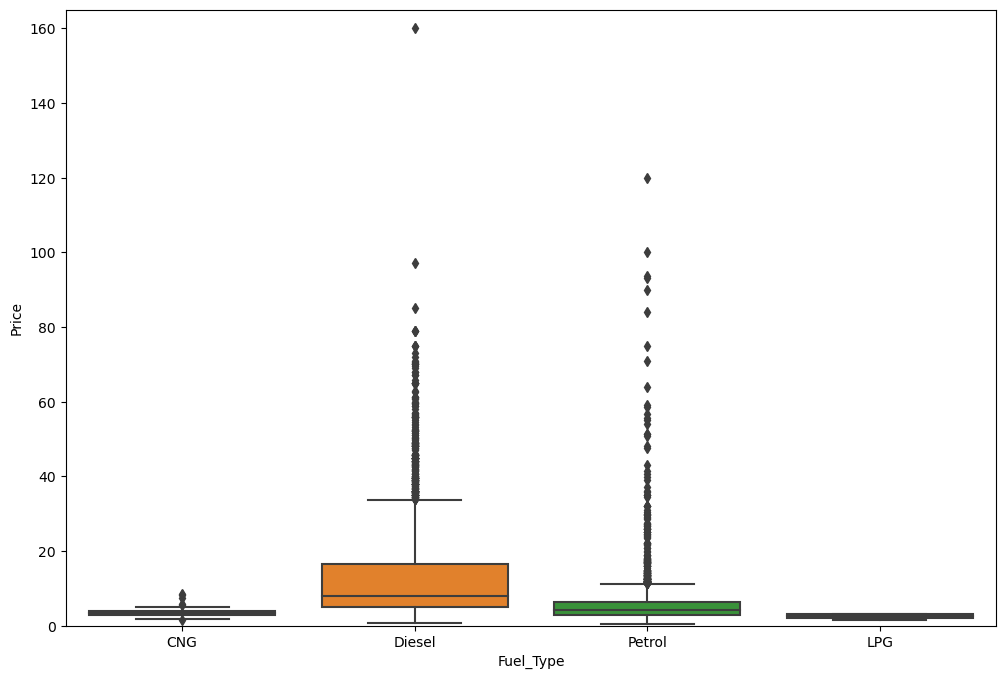

In [28]:
var = 'Fuel_Type'
data = pd.concat([train_data['Price'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=165);

전체적으로 우상향임을 확인할 수 있고, 2013년부터는 분포도를 벗어난 가격이 큰 데이터들이 꾸준히 많은 것을 확인할 수 있다.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '1998.0'),
  Text(1, 0, '1999.0'),
  Text(2, 0, '2000.0'),
  Text(3, 0, '2001.0'),
  Text(4, 0, '2002.0'),
  Text(5, 0, '2003.0'),
  Text(6, 0, '2004.0'),
  Text(7, 0, '2005.0'),
  Text(8, 0, '2006.0'),
  Text(9, 0, '2007.0'),
  Text(10, 0, '2008.0'),
  Text(11, 0, '2009.0'),
  Text(12, 0, '2010.0'),
  Text(13, 0, '2011.0'),
  Text(14, 0, '2012.0'),
  Text(15, 0, '2013.0'),
  Text(16, 0, '2014.0'),
  Text(17, 0, '2015.0'),
  Text(18, 0, '2016.0'),
  Text(19, 0, '2017.0'),
  Text(20, 0, '2018.0'),
  Text(21, 0, '2019.0')])

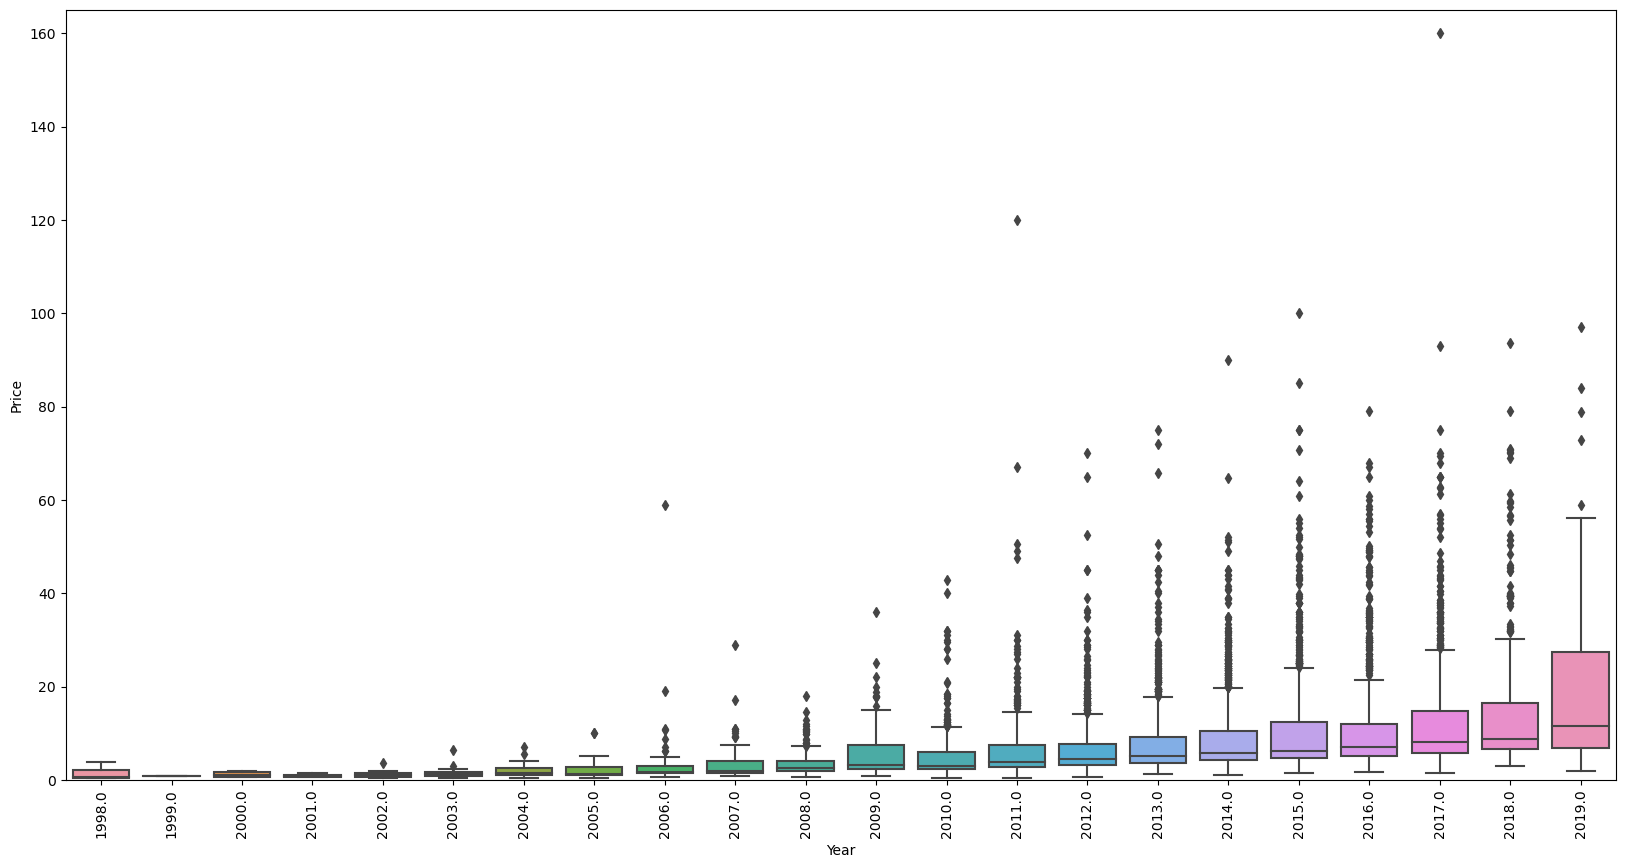

In [29]:
var = 'Year'
data = pd.concat([train_data['Price'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=165)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Owner_Type', ylabel='Price'>

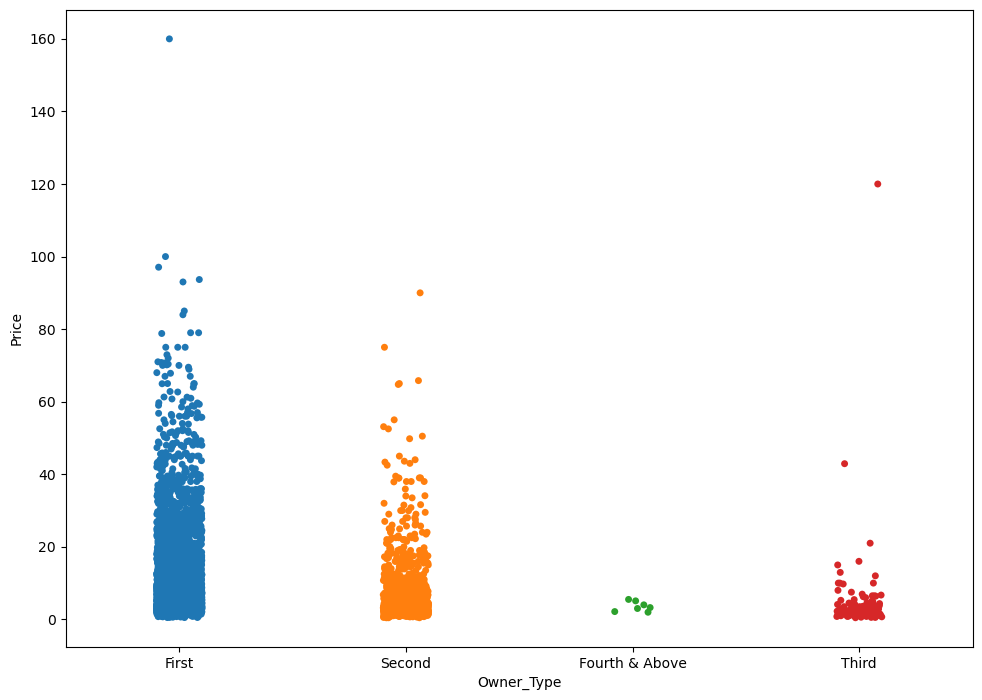

In [30]:
var = 'Owner_Type'
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.stripplot(x = var, y ='Price', data = train_data) 

<Figure size 2000x1000 with 0 Axes>

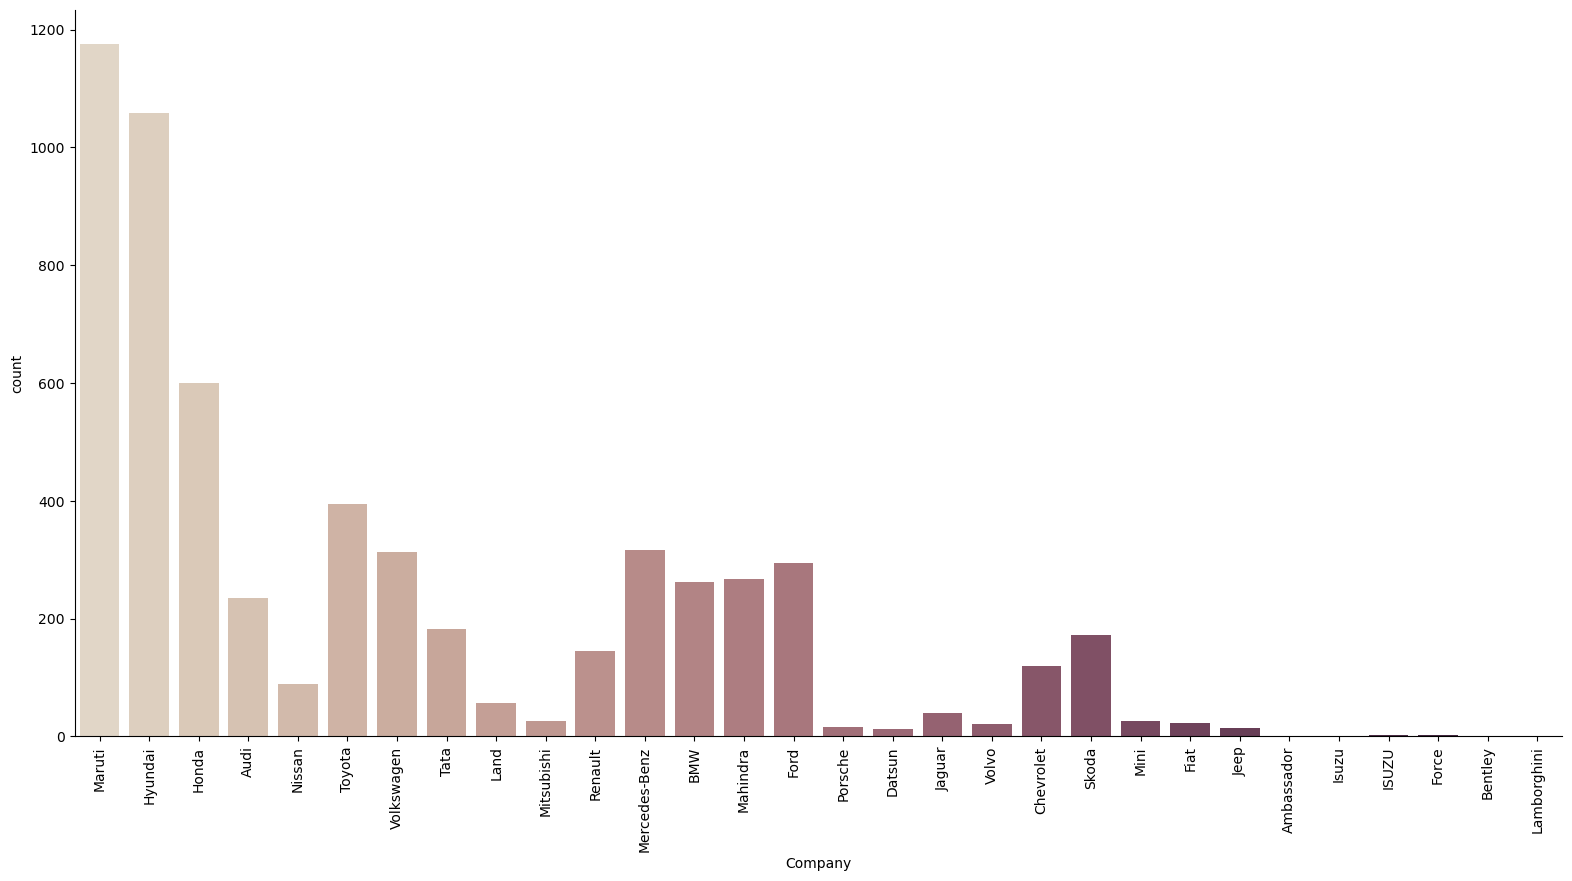

In [31]:
var = "Company"
plt.figure(figsize=(20, 10))
sns.catplot(x=var, kind="count", palette="ch:.25", height=8, aspect=2, data=train_data);
plt.xticks(rotation=90);

아래의 차트를 보면 가격과 회사의 관계가 명확하지 않음, 회사와 관련된 데이터가 많으니, 상위권회사 - 하위권회사에 대한 명확한 구분도 어려우니 일단 제거하고 시작.

<function matplotlib.pyplot.show(close=None, block=None)>

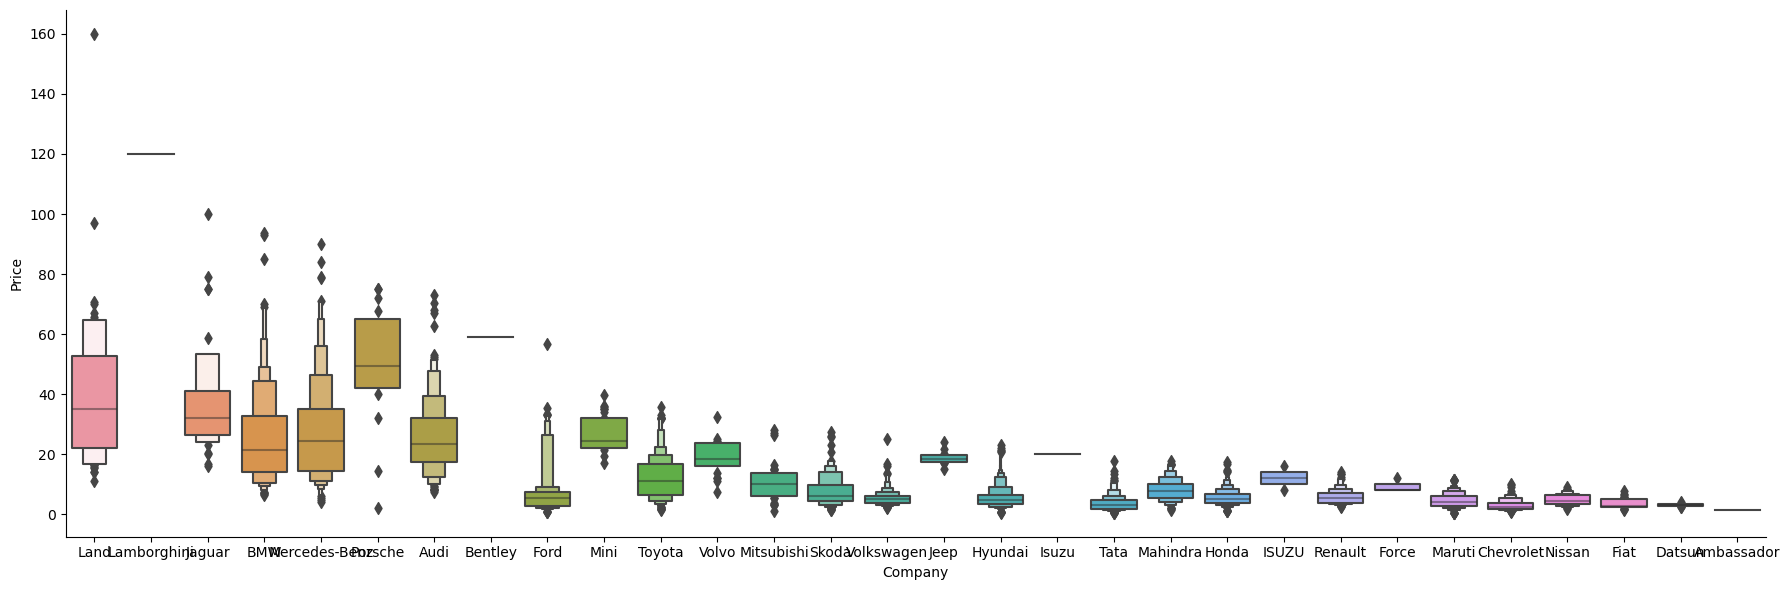

In [32]:
# Plot Company vs Price
# Yes we did this earlier... but used here for the work required here
sns.catplot(y='Price',x=var,data= train_data.sort_values('Price',ascending=False),kind="boxen",height=6, aspect=3)
plt.show

In [33]:
train_data.drop(labels="Company",axis=1,inplace=True)

숫자로 표현할 수 있는(1234) owner type 처리

In [34]:
train_data.replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)
train_data.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),New_car_Price
0,Mumbai,2010.0,72000.0,CNG,Manual,1,5.0,1.75,26.60,998.0,58.16,NaN
1,Pune,2015.0,41000.0,Diesel,Manual,1,5.0,12.50,19.67,1582.0,126.20,NaN
2,Chennai,2011.0,46000.0,Petrol,Manual,1,5.0,4.50,18.20,1199.0,88.70,8.61
3,Chennai,2012.0,87000.0,Diesel,Manual,1,7.0,6.00,20.77,1248.0,88.76,NaN
4,Coimbatore,2013.0,40670.0,Diesel,Automatic,2,5.0,17.74,15.20,1968.0,140.80,NaN


In [35]:
train_data.dtypes

Location              object
Year                 float64
Kilometers_Driven    float64
Fuel_Type             object
Transmission          object
Owner_Type             int64
Seats                float64
Price                float64
Mileage(km/kg)       float64
Engine(CC)           float64
Power(bhp)           float64
New_car_Price        float64
dtype: object

#### one_hot_encoding

In [36]:
#나머진 원핫인코딩
one_hot_encode_cols = train_data.dtypes[train_data.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

for col in one_hot_encode_cols:
    train_data[col] = pd.Categorical(train_data[col])

# Do the one hot encoding
train_data = pd.get_dummies(train_data, columns=one_hot_encode_cols)

In [37]:
train_data.head()

,Year,Kilometers_Driven,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),New_car_Price,Location_Ahmedabad,...,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
0,2010.0,72000.0,1,5.0,1.75,26.60,998.0,58.16,NaN,0,...,0,0,1,0,1,0,0,0,0,1
1,2015.0,41000.0,1,5.0,12.50,19.67,1582.0,126.20,NaN,0,...,0,0,0,1,0,1,0,0,0,1
2,2011.0,46000.0,1,5.0,4.50,18.20,1199.0,88.70,8.61,0,...,0,0,0,0,0,0,0,1,0,1
3,2012.0,87000.0,1,7.0,6.00,20.77,1248.0,88.76,NaN,0,...,0,0,0,0,0,1,0,0,0,1
4,2013.0,40670.0,2,5.0,17.74,15.20,1968.0,140.80,NaN,0,...,0,0,0,0,0,1,0,0,1,0


In [38]:
train_data.drop(["New_car_Price"],axis=1,inplace=True)

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    5872 non-null   float64
 1   Kilometers_Driven       5872 non-null   float64
 2   Owner_Type              5872 non-null   int64  
 3   Seats                   5872 non-null   float64
 4   Price                   5872 non-null   float64
 5   Mileage(km/kg)          5872 non-null   float64
 6   Engine(CC)              5872 non-null   float64
 7   Power(bhp)              5872 non-null   float64
 8   Location_Ahmedabad      5872 non-null   uint8  
 9   Location_Bangalore      5872 non-null   uint8  
 10  Location_Chennai        5872 non-null   uint8  
 11  Location_Coimbatore     5872 non-null   uint8  
 12  Location_Delhi          5872 non-null   uint8  
 13  Location_Hyderabad      5872 non-null   uint8  
 14  Location_Jaipur         5872 non-null   

In [40]:
one_hot_encode_cols = train_data.dtypes[train_data.dtypes != float]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

for col in one_hot_encode_cols:
    train_data[col] = train_data[col].astype(float)

In [41]:
train_data.dtypes

Year                      float64
Kilometers_Driven         float64
Owner_Type                float64
Seats                     float64
Price                     float64
Mileage(km/kg)            float64
Engine(CC)                float64
Power(bhp)                float64
Location_Ahmedabad        float64
Location_Bangalore        float64
Location_Chennai          float64
Location_Coimbatore       float64
Location_Delhi            float64
Location_Hyderabad        float64
Location_Jaipur           float64
Location_Kochi            float64
Location_Kolkata          float64
Location_Mumbai           float64
Location_Pune             float64
Fuel_Type_CNG             float64
Fuel_Type_Diesel          float64
Fuel_Type_LPG             float64
Fuel_Type_Petrol          float64
Transmission_Automatic    float64
Transmission_Manual       float64
dtype: object

In [42]:
train, test = train_test_split(train_data, random_state=42, test_size=0.3)


In [43]:
y_train = train.Price
train_x = train.drop(labels="Price", axis = 1)
y_test = test.Price
test_x = test.drop(labels="Price", axis = 1)

In [44]:
train_x.head()

,Year,Kilometers_Driven,Owner_Type,Seats,Mileage(km/kg),Engine(CC),Power(bhp),Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
2680,2018.0,20604.0,1.0,5.0,19.27,2143.0,167.62,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
759,2010.0,81245.0,1.0,5.0,18.90,998.0,67.10,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4570,2016.0,21000.0,1.0,5.0,21.40,1197.0,83.10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3606,2013.0,51000.0,1.0,5.0,19.08,1582.0,126.32,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1426,2011.0,116000.0,2.0,5.0,21.43,1364.0,138.00,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [45]:
y_train = y_train.astype(int)
y_train.head()
y_test = y_test.astype(int)

In [46]:
train_x.shape
train_x.dtypes

Year                      float64
Kilometers_Driven         float64
Owner_Type                float64
Seats                     float64
Mileage(km/kg)            float64
Engine(CC)                float64
Power(bhp)                float64
Location_Ahmedabad        float64
Location_Bangalore        float64
Location_Chennai          float64
Location_Coimbatore       float64
Location_Delhi            float64
Location_Hyderabad        float64
Location_Jaipur           float64
Location_Kochi            float64
Location_Kolkata          float64
Location_Mumbai           float64
Location_Pune             float64
Fuel_Type_CNG             float64
Fuel_Type_Diesel          float64
Fuel_Type_LPG             float64
Fuel_Type_Petrol          float64
Transmission_Automatic    float64
Transmission_Manual       float64
dtype: object

In [47]:
y_train.dtype

dtype('int64')

In [48]:
dt = DecisionTreeRegressor(random_state=42)
dt = dt.fit(train_x, y_train)

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
mean_squared_error(y_test,dt.predict(test_x))**0.5

5.500012898550555

<AxesSubplot:xlabel='preds', ylabel='actual'>

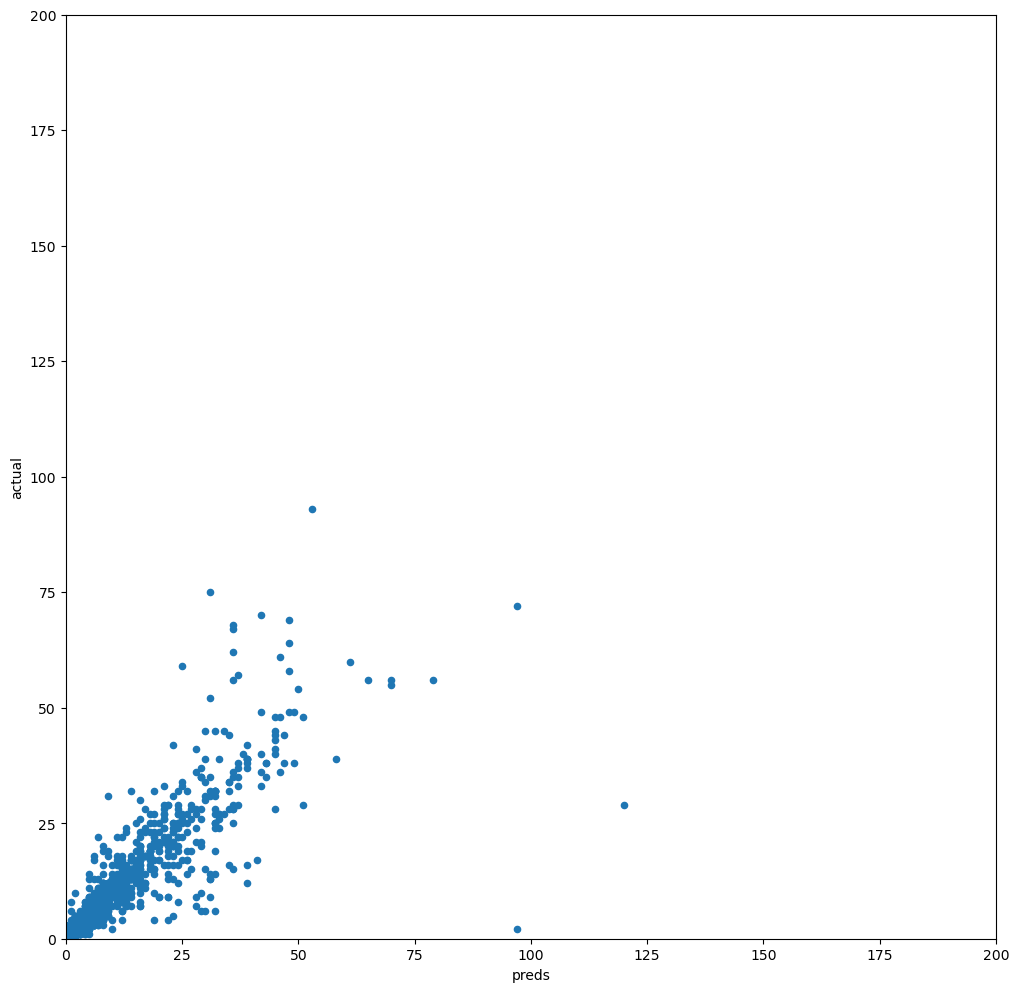

In [51]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
two = pd.DataFrame({"preds": dt.predict(test_x), "true":y_test})
two["actual"] = two["true"]

two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 200], ylim=[0,200])

[Text(0.6964487601289442, 0.9821428571428571, 'X[6] <= 164.85\nsquared_error = 135.013\nsamples = 4110\nvalue = 9.26'),
 Text(0.47875164281185384, 0.9464285714285714, 'X[5] <= 1958.0\nsquared_error = 19.546\nsamples = 3365\nvalue = 5.415'),
 Text(0.2764225718150704, 0.9107142857142857, 'X[0] <= 2013.5\nsquared_error = 8.619\nsamples = 2876\nvalue = 4.522'),
 Text(0.12511100108224146, 0.875, 'X[6] <= 103.4\nsquared_error = 2.753\nsamples = 1250\nvalue = 2.855'),
 Text(0.0600328297305987, 0.8392857142857143, 'X[0] <= 2010.5\nsquared_error = 1.563\nsamples = 931\nvalue = 2.378'),
 Text(0.0203284427446745, 0.8035714285714286, 'X[0] <= 2007.5\nsquared_error = 0.759\nsamples = 365\nvalue = 1.526'),
 Text(0.00802910372465148, 0.7678571428571429, 'X[0] <= 2005.5\nsquared_error = 0.379\nsamples = 112\nvalue = 0.848'),
 Text(0.003183219883755631, 0.7321428571428571, 'X[5] <= 1374.0\nsquared_error = 0.25\nsamples = 47\nvalue = 0.511'),
 Text(0.0022737284883968794, 0.6964285714285714, 'X[13] <= 0.

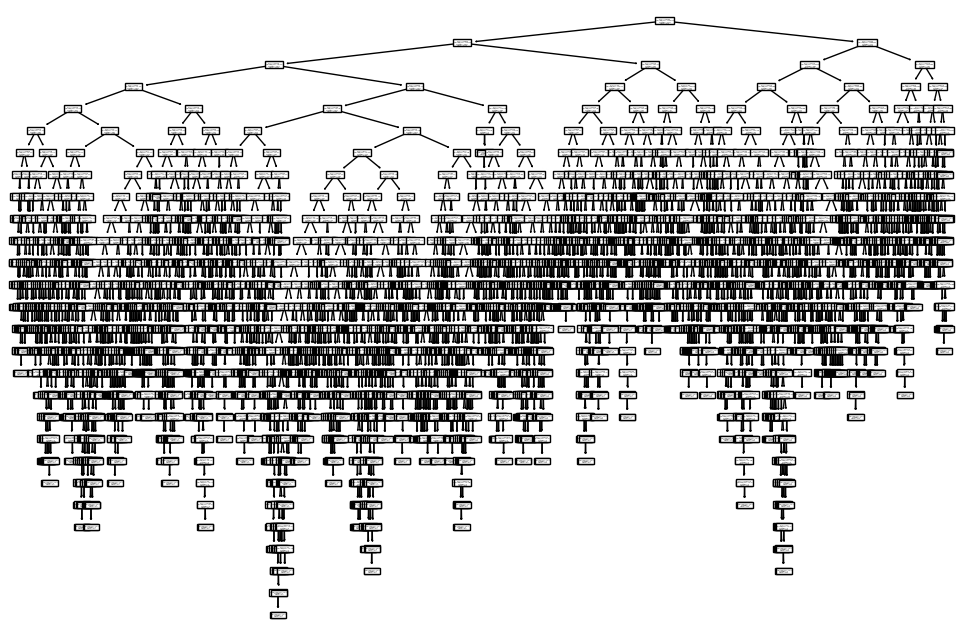

In [73]:
plt.figure(figsize=(12,8))

from sklearn import tree
tree.plot_tree(dt.fit(train_x, y_train)) 

### Grid search 를 통한 하이퍼 파라미터 튜닝

In [52]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

In [53]:
GR = GridSearchCV(dt, param_grid=param_grid, scoring='neg_mean_squared_error')
GR.fit(train_x, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(1, 28, 2),
                         'max_features': range(1, 25)},
             scoring='neg_mean_squared_error')

In [54]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(2605, 13)

In [55]:
print(mean_squared_error(y_test,GR.predict(test_x))**0.5)
print(mean_squared_error(y_train,GR.predict(train_x))**0.5)


5.455745878598933
0.9493874595107062


위를 수치식을 보면, Train 에서는 완벽하지만, Test는 정반대이다. 이를 통해 Overfitting 을 확인할 수 있다.
### Overfitting 완화시도

overfitting 완화전 사진(비교용으로 둠)

<AxesSubplot:xlabel='preds', ylabel='actual'>

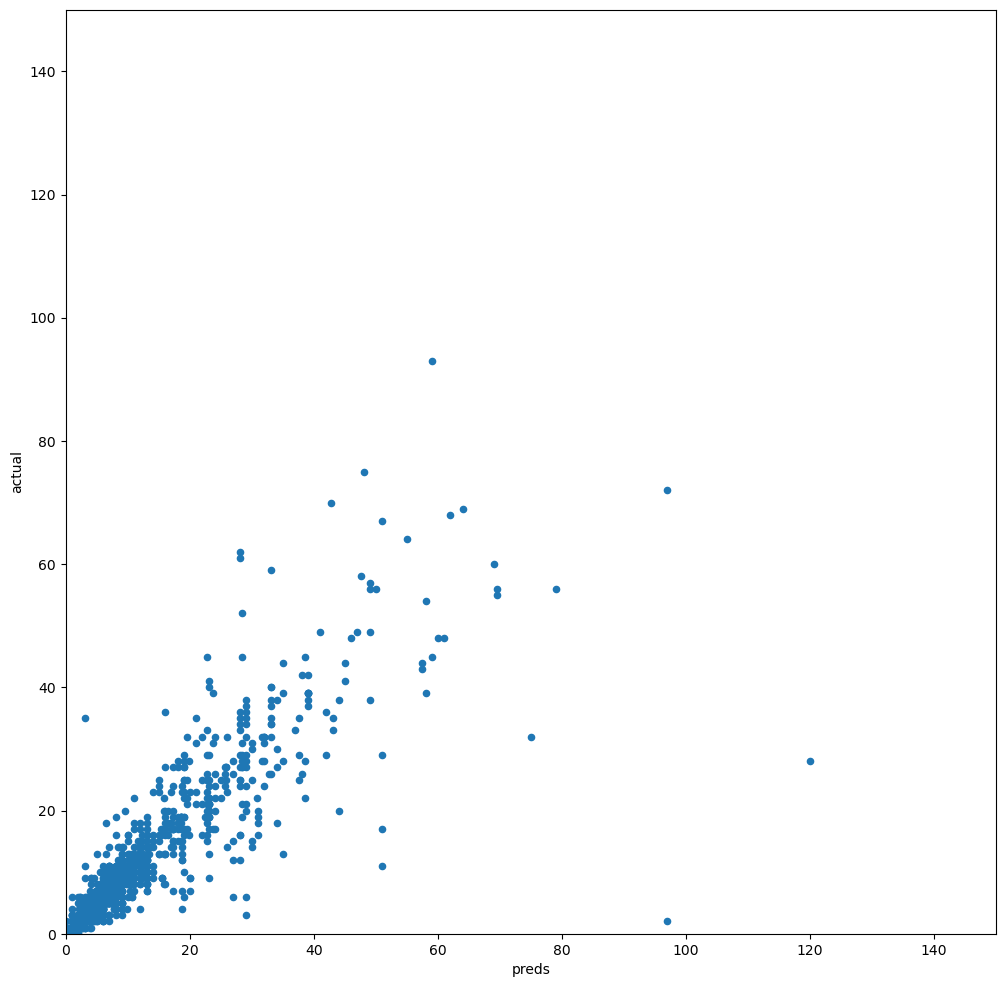

In [56]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
two = pd.DataFrame({"preds": GR.predict(test_x), "true":y_test})
two["actual"] = two["true"]

two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 150], ylim=[0,150])

#### Pred_pruning

여기부분 데이터 상관계수 확인 및 데이터 선택하는 부분만 잘 작성하면 될듯

#### Post_pruning

결정트리를 전체 깊이까지 성장시키고, 트리 분기를 제거해서 과적합하는 것을 방지
CCP는  사후가지치기의 한 유형, 가장 적합한 CCP의 값 == 가지치기된 트리를 찾는다.

In [57]:
path = dt.cost_complexity_pruning_path(train_x, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [58]:
score = []
alpha = []
best_alpha = 0
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(train_x, y_train)
    score.append(mean_squared_error(y_test,clf.predict(test_x))**0.5)
    alpha.append(ccp_alpha)
    

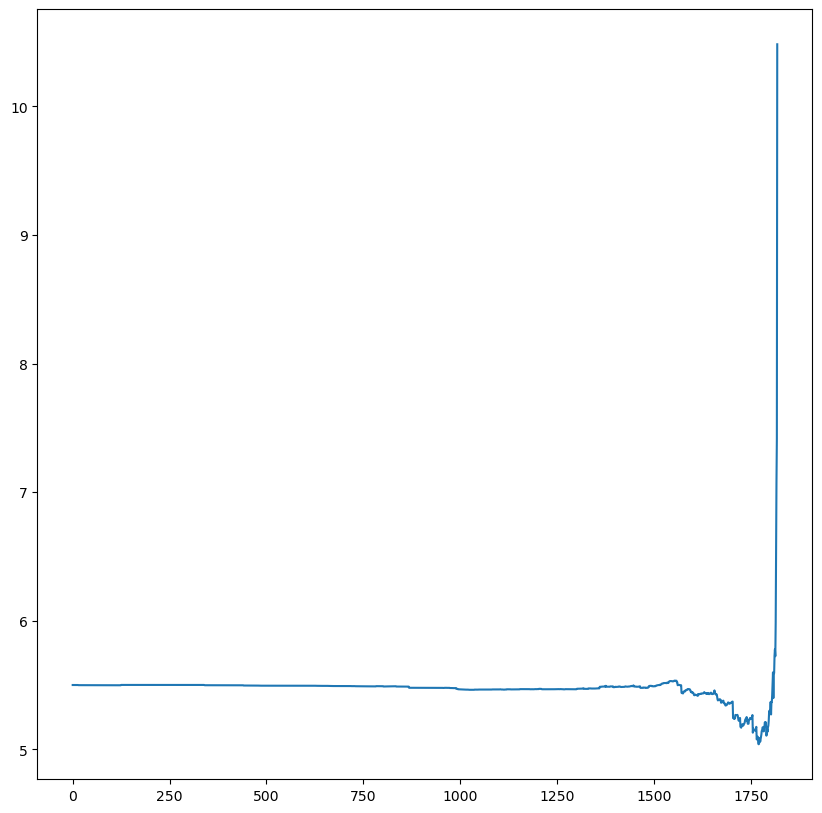

In [59]:
plt.figure(figsize=(10,10))
plt.plot(score)

In [60]:
best_alpha = alpha[np.argmin(score)]

In [72]:
next = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha, max_depth=13)
next.fit(train_x, y_train)
print("Rmse : ", mean_squared_error(y_test,next.predict(test_x))**0.5)
print("Accuracy on Traing set: ",next.score(train_x,y_train))
print("Accuracy on Testing set: ",next.score(test_x,y_test))

Rmse :  5.041860611034489
Accuracy on Traing set:  0.9145311697392633
Accuracy on Testing set:  0.7682652940326944


<AxesSubplot:xlabel='preds', ylabel='actual'>

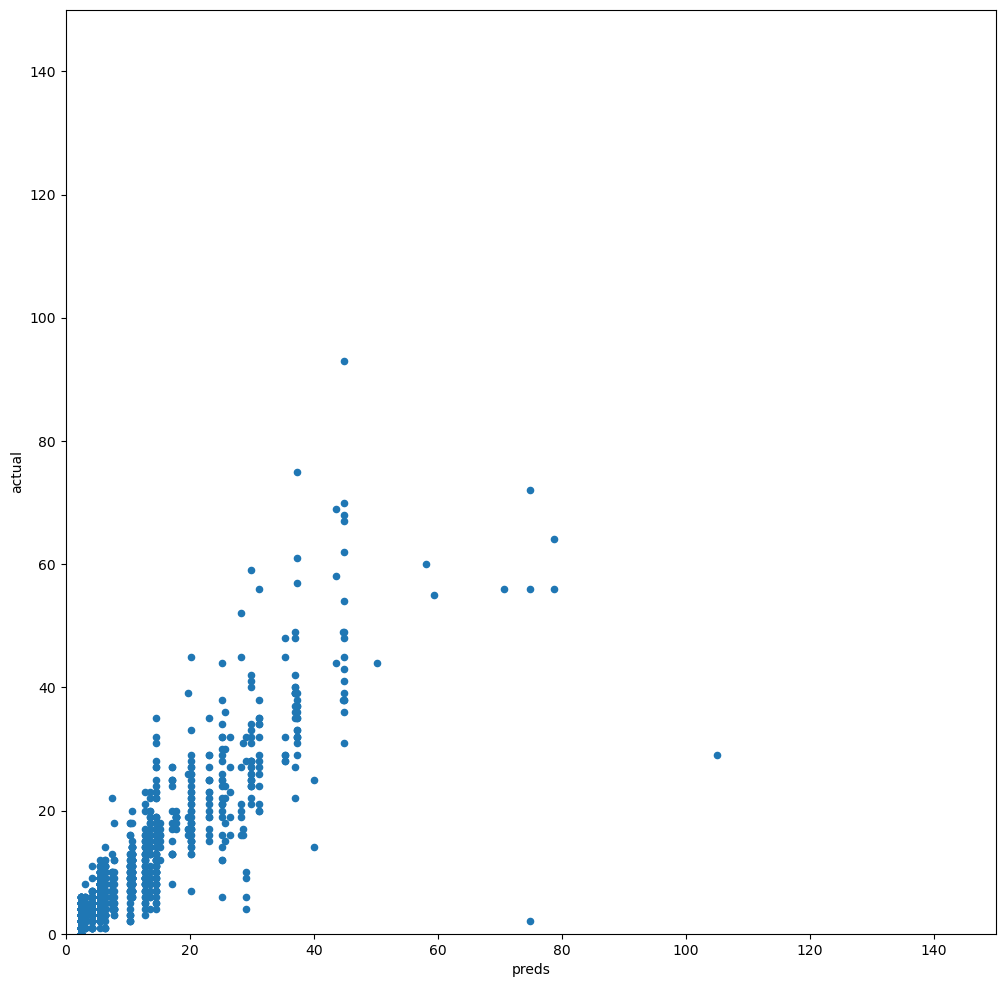

In [62]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
two = pd.DataFrame({"preds": next.predict(test_x), "true":y_test})
two["actual"] = two["true"]

two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 150], ylim=[0,150])

#### dt기반 앙상블 모델 : Random Forest.
가장 우수한 성능을 보임

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_x, y_train)
mean_squared_error(y_test,rf.predict(test_x))**0.5

3.7793213100801744

In [ ]:
print("Accuracy on Traing set: ",rf.score(train_x,y_train))
print("Accuracy on Testing set: ",rf.score(test_x,y_test))

Accuracy on Traing set:  0.9757482225204354
Accuracy on Testing set:  0.8697921871113656


<AxesSubplot:xlabel='preds', ylabel='actual'>

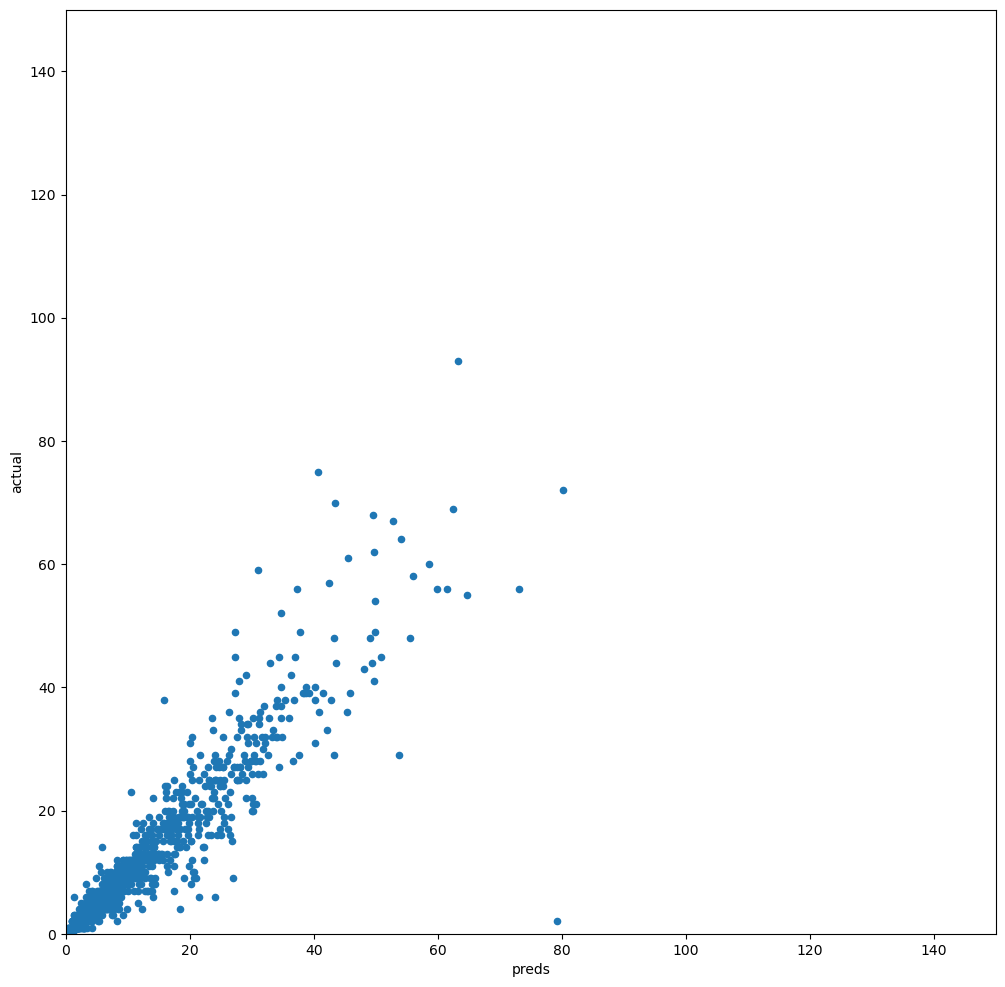

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
two = pd.DataFrame({"preds": rf.predict(test_x), "true":y_test})
two["actual"] = two["true"]

two.plot(x = "preds", y = "actual",kind = "scatter", xlim = [0, 150], ylim=[0,150])